In [1]:
import pandas as pd
import numpy as np
import unicodedata
import pythainlp
# from pythainlp import util, word_tokenize
from datasets import Dataset, DatasetDict
from sentence_transformers import SentenceTransformer, util
from nltk.translate.bleu_score import sentence_bleu

In [64]:
train = pd.read_json("./LimeSoda/dataset_train_wo_tokentags_v1/train_v1.jsonl", lines=True)
test = pd.read_json("./LimeSoda/dataset_train_wo_tokentags_v1/test_v1.jsonl", lines=True)
val = pd.read_json("./LimeSoda/dataset_train_wo_tokentags_v1/val_v1.jsonl", lines=True)

In [65]:
train

,Text,Document Tag
0,"[เพื่อน, ๆ, , , รู้, ไหม, ครับ, ว่า, , , "", กา...",Fact News
1,"[เทรนด์, กิ๊บเก๋, ..., ป้องกัน, โรค, |||, ฮัดเ...",Fact News
2,"[สถาน, เอกอัครราชทูต, คูเวต, , , งด, ออกวี, ซ่...",Fact News
3,"[สั่ง, ตรวจสอบ, "", ลูก, ตุ้ม, พลังธาตุ, "", ของ...",Fact News
4,"[เรา, ไม่, รู้, ว่า, Covid, -, 19, กลัว, ขิง, ...",Fake News
...,...,...
2693,"[SaaPannisa, ไข่, มุก, นั้น, ทำ, มา, จาก, แป้ง...",Fake News
2694,"[ออก, กำลัง, กาย, ไล่, ความ, ดัน, โลหิต, สูง, ...",Fact News
2695,"[‘, ผู้, ชาย, -, คน, อ้วน, ’, เสี่ยง, ป่วย, หน...",Fact News
2696,"[กระเทียม, สุด, ยอด, ผัก, จริง, ๆ, ตั้งแต่, ค,...",Fake News


In [66]:
test

,Text,Token Tags,Document Tag
0,"[ประกาศ, กฎอัยการศึก, ปิด, การ, เข้า, ออก, ทุก...","[T-Clickbait, T-Clickbait, , , , , , , , , , ,...",Undefined
1,"[ประโยชน์, มาก, ก็, ใช่, ว่า, จะ, ไม่มี, โทษ, ...","[, , , , , , , , , , M-Convincing, M-Convincin...",Undefined
2,"[มั่นใจ, กระซิบหูหนู, พระพิฆเนศ, ไม่ติด, เชื้อ...","[T-Clickbait, T-Clickbait, T-Clickbait, T-Clic...",Fake News
3,"[พวก, ที่, เชื่อ, ว่า, คน, ไม่, ป่วย, ไม่, ต้อ...","[, , , , , , , , , , , , , , , , , , , , , , ,...",Undefined
4,"[มัน, คือ, น้ำ, ศักดิ์สิทธิ์, ไว้, รักษา, คน, ...","[Fb-Refer, Fb-Refer, Fb-Over, Fb-Over, Fb-Over...",Fake News
...,...,...,...
2760,"[ตอน, นี้, คน, ที่, รู้จัก, กิน, ใบ, ทุเรียน, ...","[, , , , , Fb-Refer, Fb-Refer, Fb-Refer, Fb-Re...",Fake News
2761,"[เอา, แล้ว, โชว์, เหนือ, เกาหลี, เค้า, วิจัย, ...","[S-Satire, S-Satire, S-Satire, S-Satire, , , I...",Undefined
2762,"[เคล็ด, ลับ, 5, วิธี, เสก, ความ, อึ๋ม, ง่ายๆ, ...","[, , , , T-Clickbait, T-Clickbait, T-Clickbait...",Undefined
2763,"[หมอ, ใหญ่, เมือง, เลย, เตือน, !, !, ชาว, บ้าน...","[, , , , T-Clickbait, T-Clickbait, T-Clickbait...",Undefined


In [67]:
val

,Text,Document Tag
0,"[เตือน, ผู้, ปกครอง, เฝ้า, ระวัง, อาการ, แทรกซ...",Fact News
1,"[โรค, ติด, เชื้อ, ไวรัส, โคโรนา, , , 2019, Cor...",Fact News
2,"[เปิดใจ, !, สาว, เจอ, เมือกปริศนา, ใน, ช่อง, ค...",Fact News
3,"[#, ค่า, พีเอช, คือ, ความ, เป็น, ด่าง, ที่, มี...",Fake News
4,"[เรา, กำลัง, งง, กับ, คน, ฮ่องกง, ที่, มี, ข่า...",Fake News
...,...,...
295,"[เอ็นจีโอ, ติง, กม., ห้าม, แจก, ‘, เข็มฉีด, ยา...",Fact News
296,"[หมอ, เตือน, เลี่ยง, กิน, หมู, ดิบ, เสี่ยง, โร...",Fact News
297,"[ชาว, บ้าน, แห่, เก็บ#, ต้น, อังกาบ, หนู, •, ช...",Fake News
298,"[ง่าย, มาก, ๆ, , , วิธี, กำจัด, , , “, ติ่ง, เ...",Fake News


In [68]:
df = pd.concat([train, test, val]).drop(columns=['Token Tags'])

In [69]:
df['Document Tag'].value_counts()

Undefined    2327
Fake News    1878
Fact News    1558
Name: Document Tag, dtype: int64

In [70]:
df = df[df["Document Tag"].str.contains("Undefined") == False]

In [71]:
df['Document Tag'].value_counts()

Fake News    1878
Fact News    1558
Name: Document Tag, dtype: int64

In [72]:
df

,Text,Document Tag
0,"[เพื่อน, ๆ, , , รู้, ไหม, ครับ, ว่า, , , "", กา...",Fact News
1,"[เทรนด์, กิ๊บเก๋, ..., ป้องกัน, โรค, |||, ฮัดเ...",Fact News
2,"[สถาน, เอกอัครราชทูต, คูเวต, , , งด, ออกวี, ซ่...",Fact News
3,"[สั่ง, ตรวจสอบ, "", ลูก, ตุ้ม, พลังธาตุ, "", ของ...",Fact News
4,"[เรา, ไม่, รู้, ว่า, Covid, -, 19, กลัว, ขิง, ...",Fake News
...,...,...
295,"[เอ็นจีโอ, ติง, กม., ห้าม, แจก, ‘, เข็มฉีด, ยา...",Fact News
296,"[หมอ, เตือน, เลี่ยง, กิน, หมู, ดิบ, เสี่ยง, โร...",Fact News
297,"[ชาว, บ้าน, แห่, เก็บ#, ต้น, อังกาบ, หนู, •, ช...",Fake News
298,"[ง่าย, มาก, ๆ, , , วิธี, กำจัด, , , “, ติ่ง, เ...",Fake News


In [73]:
df['Text'] = df['Text'].map(lambda x: ''.join(x))

In [74]:
df

,Text,Document Tag
0,"เพื่อนๆรู้ไหมครับว่า""การล้างมือ""มีความสำคัญและ...",Fact News
1,เทรนด์กิ๊บเก๋...ป้องกันโรค|||ฮัดเช้ยยยย...!!ช่...,Fact News
2,สถานเอกอัครราชทูตคูเวตงดออกวีซ่าแก่คนต่างชาติร...,Fact News
3,"สั่งตรวจสอบ""ลูกตุ้มพลังธาตุ""ของขลังฆ่าโควิด-19...",Fact News
4,เราไม่รู้ว่าCovid-19กลัวขิงกับกัญชาจริงหรือไม่...,Fake News
...,...,...
295,เอ็นจีโอติงกม.ห้ามแจก‘เข็มฉีดยา’ลดติดเชื้อเอชไ...,Fact News
296,หมอเตือนเลี่ยงกินหมูดิบเสี่ยงโรคไข้หูดับ|||หมอ...,Fact News
297,ชาวบ้านแห่เก็บ#ต้นอังกาบหนู•ชาวบ้านแห่เข้าไปเก...,Fake News
298,ง่ายมากๆวิธีกำจัด“ติ่งเนื้อ”ด้วยวิธีธรรมชาติหา...,Fake News


In [75]:
df['Document Tag'] = np.where(df['Document Tag'] == 'Fact News', 0, 1)

In [76]:
df

,Text,Document Tag
0,"เพื่อนๆรู้ไหมครับว่า""การล้างมือ""มีความสำคัญและ...",0
1,เทรนด์กิ๊บเก๋...ป้องกันโรค|||ฮัดเช้ยยยย...!!ช่...,0
2,สถานเอกอัครราชทูตคูเวตงดออกวีซ่าแก่คนต่างชาติร...,0
3,"สั่งตรวจสอบ""ลูกตุ้มพลังธาตุ""ของขลังฆ่าโควิด-19...",0
4,เราไม่รู้ว่าCovid-19กลัวขิงกับกัญชาจริงหรือไม่...,1
...,...,...
295,เอ็นจีโอติงกม.ห้ามแจก‘เข็มฉีดยา’ลดติดเชื้อเอชไ...,0
296,หมอเตือนเลี่ยงกินหมูดิบเสี่ยงโรคไข้หูดับ|||หมอ...,0
297,ชาวบ้านแห่เก็บ#ต้นอังกาบหนู•ชาวบ้านแห่เข้าไปเก...,1
298,ง่ายมากๆวิธีกำจัด“ติ่งเนื้อ”ด้วยวิธีธรรมชาติหา...,1


In [77]:
df.rename(columns={"Text": "text", "Document Tag": "label"}, inplace=True)

In [78]:
df

,text,label
0,"เพื่อนๆรู้ไหมครับว่า""การล้างมือ""มีความสำคัญและ...",0
1,เทรนด์กิ๊บเก๋...ป้องกันโรค|||ฮัดเช้ยยยย...!!ช่...,0
2,สถานเอกอัครราชทูตคูเวตงดออกวีซ่าแก่คนต่างชาติร...,0
3,"สั่งตรวจสอบ""ลูกตุ้มพลังธาตุ""ของขลังฆ่าโควิด-19...",0
4,เราไม่รู้ว่าCovid-19กลัวขิงกับกัญชาจริงหรือไม่...,1
...,...,...
295,เอ็นจีโอติงกม.ห้ามแจก‘เข็มฉีดยา’ลดติดเชื้อเอชไ...,0
296,หมอเตือนเลี่ยงกินหมูดิบเสี่ยงโรคไข้หูดับ|||หมอ...,0
297,ชาวบ้านแห่เก็บ#ต้นอังกาบหนู•ชาวบ้านแห่เข้าไปเก...,1
298,ง่ายมากๆวิธีกำจัด“ติ่งเนื้อ”ด้วยวิธีธรรมชาติหา...,1


In [79]:
df['label'].value_counts()

1    1878
0    1558
Name: label, dtype: int64

In [80]:
df.drop_duplicates(inplace=True)

In [81]:
df['label'].value_counts()

1    1836
0    1540
Name: label, dtype: int64

Normalize Text

In [82]:
def normalize_double_quote(text: str):
    all_quote = [
    '“', # U+201c
    '”', # U+201d
    "„", # U+201e
    '«', # U+00AB
    '»', # U+00BB
    '„', # U+201E
    '“', # U+201C
    '‟', # U+201F
    '”', # U+201D
    '❝', # U+275D
    '❞', # U+275E
    '〝', # U+301D
    '〞', # U+301E
    '〟', # U+301F
    '＂', # U+FF02
    ]
    std_quote = "\"" #U+0022
    table = str.maketrans(dict.fromkeys(all_quote, std_quote))
    return text.translate(table)

In [84]:
def normalize_single_quote(text: str):
    all_quote = ['\u02BB', '\u02BC', '\u066C', '\u2018', '\u2019', '\u201A', '\u275B', '\u275C']
    std_quote = "\'"
    table = str.maketrans(dict.fromkeys(all_quote, std_quote))
    return text.translate(table)

In [92]:
def preprocess_func(text):
    new_text = unicodedata.normalize('NFKD', text)
    new_text = pythainlp.util.normalize(new_text)
    new_text = normalize_double_quote(new_text)
    new_text = normalize_single_quote(new_text)
    return new_text

In [93]:
df

,text,label
0,"เพื่อนๆรู้ไหมครับว่า""การล้างมือ""มีความสำคัญและ...",0
1,เทรนด์กิ๊บเก๋...ป้องกันโรค|||ฮัดเช้ยยยย...!!ช่...,0
2,สถานเอกอัครราชทูตคูเวตงดออกวีซ่าแก่คนต่างชาติร...,0
3,"สั่งตรวจสอบ""ลูกตุ้มพลังธาตุ""ของขลังฆ่าโควิด-19...",0
4,เราไม่รู้ว่าCovid-19กลัวขิงกับกัญชาจริงหรือไม่...,1
...,...,...
295,เอ็นจีโอติงกม.ห้ามแจก‘เข็มฉีดยา’ลดติดเชื้อเอชไ...,0
296,หมอเตือนเลี่ยงกินหมูดิบเสี่ยงโรคไข้หูดับ|||หมอ...,0
297,ชาวบ้านแห่เก็บ#ต้นอังกาบหนู•ชาวบ้านแห่เข้าไปเก...,1
298,ง่ายมากๆวิธีกำจัด“ติ่งเนื้อ”ด้วยวิธีธรรมชาติหา...,1


In [94]:
df['text'] = df['text'].map(lambda x: preprocess_func(x))

In [95]:
df

,text,label
0,"เพื่อนๆรู้ไหมครับว่า""การล้างมือ""มีความสำคัญและ...",0
1,เทรนด์กิ๊บเก๋...ป้องกันโรค|||ฮัดเช้ยยยย...!!ช่...,0
2,สถานเอกอัครราชทูตคูเวตงดออกวีซ่าแก่คนต่างชาติร...,0
3,"สั่งตรวจสอบ""ลูกตุ้มพลังธาตุ""ของขลังฆ่าโควิด-19...",0
4,เราไม่รู้ว่าCovid-19กลัวขิงกับกัญชาจริงหรือไม่...,1
...,...,...
295,เอ็นจีโอติงกม.ห้ามแจก'เข็มฉีดยา'ลดติดเชื้อเอชไ...,0
296,หมอเตือนเลี่ยงกินหมูดิบเสี่ยงโรคไข้หูดับ|||หมอ...,0
297,ชาวบ้านแห่เก็บ#ต้นอังกาบหนู•ชาวบ้านแห่เข้าไปเก...,1
298,"ง่ายมากๆวิธีกำจัด""ติ่งเนื้อ""ด้วยวิธีธรรมชาติหา...",1


In [102]:
df['label'].value_counts()

1    1836
0    1540
Name: label, dtype: int64

Split data

In [103]:
fake_news_data = Dataset.from_pandas(df)

In [104]:
fake_news_data

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 3376
})

In [105]:
fake_news_data.remove_columns('__index_level_0__')

Dataset({
    features: ['text', 'label'],
    num_rows: 3376
})

In [106]:
train_testvalid = fake_news_data.train_test_split(test_size=0.3) # 70% train, 30% test + validation
test_valid = train_testvalid['test'].train_test_split(test_size=0.5) # Split the 30% test + valid in half test, half valid
train_test_valid_dataset = DatasetDict({
    'train': train_testvalid['train'].remove_columns('__index_level_0__'),
    'test': test_valid['test'].remove_columns('__index_level_0__'),
    'valid': test_valid['train'].remove_columns('__index_level_0__')})

In [107]:
train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2363
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 507
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 506
    })
})

In [108]:
for split, dataset in train_test_valid_dataset.items():
    dataset.to_csv(f"{split}_data_fake_news.csv", index=None)

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Check Imbalance

In [11]:
train_df = pd.read_csv('./train_data_fake_news.csv')
val_df = pd.read_csv('./valid_data_fake_news.csv')
test_df = pd.read_csv('./test_data_fake_news.csv')

<AxesSubplot: ylabel='Frequency'>

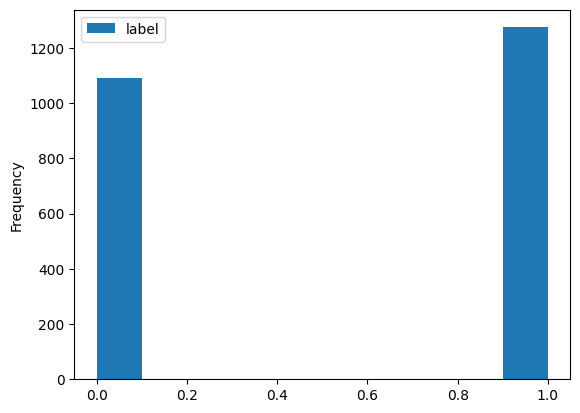

In [110]:
train_df.plot.hist()

<AxesSubplot: ylabel='Frequency'>

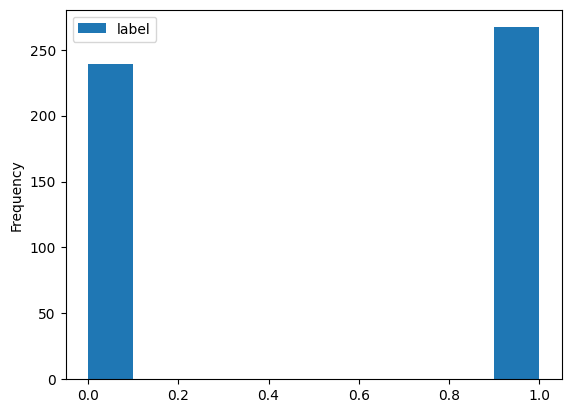

In [111]:
val_df.plot.hist()

<AxesSubplot: ylabel='Frequency'>

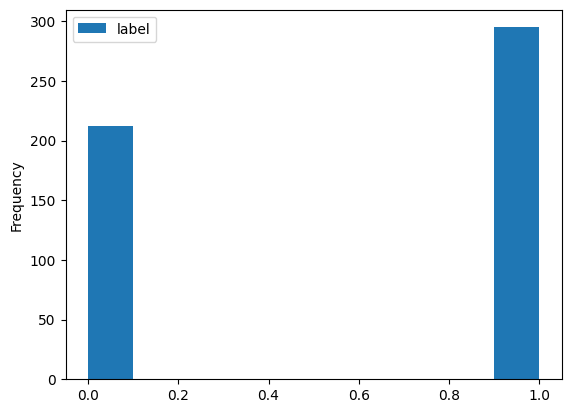

In [113]:
test_df.plot.hist()

Data Augmentation

In [4]:
df_aug = pd.read_csv("./Data Augmentation (train).csv")

In [5]:
df_aug

,text,label,th_to_en,en_to_th
0,สธ.ประชุมด่วน!มาตรการรับมือไวรัสโคโรนาสายพันธุ...,0,The Ministry of Public Health urgently convene...,กระทรวงสาธารณสุขจัดประชุมอย่างเร่งด่วน! ไวรัส ...
1,คุณทวดวัย104ปีเผยเคล็ดลับอายุยืนมีวันนี้ได้เพร...,1,"104 -year -old, revealing a long -standing sec...",104 -ปี -เปิดเผยความลับที่ยาวนานในวันนี้เนื่อง...
2,อย่าโยนทิ้ง!เปลือกมะนาวบรรเทาอาการปวดข้อให้หาย...,1,Do not throw away! Lemon shells can relieve jo...,อย่าทิ้ง! เปลือกมะนาวสามารถบรรเทาอาการปวดข้อ |...
3,หิมะถล่มฝรั่งเศส!เร่งเคลียร์ถนนบนเทือกเขาหลังน...,0,French snow! Accelerates the roads on the moun...,หิมะฝรั่งเศส! เร่งถนนบนภูเขาหลังจากนักท่องเที่...
4,ผู้เชี่ยวชาญชี้คนแห่ซื้อทิชชู่เพียงเพราะแตกตื่...,0,Specialist pointed out that people flocked to ...,ผู้เชี่ยวชาญชี้ให้เห็นว่าผู้คนแห่กันซื้อเนื้อเ...
...,...,...,...,...
2358,5ขั้นตอนง่ายๆในการนวดหน้าอกอัพไซส์ให้ใหญ่ขึ้นด...,1,5 simple steps to massage the chest up size to...,5 ขั้นตอนง่ายๆในการนวดขนาดหน้าอกให้ใหญ่ขึ้นด้ว...
2359,การแช่ผ้าไว้กับผงซักฟอกที่เข้มข้นพอควรแบบที่เร...,1,Soaking in the fabric with a very intense dete...,การแช่ในผ้าด้วยผงซักฟอกที่เข้มข้นมากที่เราเคยท...
2360,เผยสูตรฟันขาว5เทคนิคที่จะทำให้ฟันของคุณกลับมาข...,1,Revealing the 5 white teeth formulas that will...,การเปิดเผยสูตรฟันขาว 5 สูตรที่จะทำให้ฟันของคุณ...
2361,"องค์การเภสัชฯเดินหน้าพัฒนา""ยาฟาวิพิราเวียร์""รั...",0,The Pharmaceutical Organization continues to d...,"องค์กรเภสัชกรรมยังคงพัฒนา ""favidipravier"" เพื่..."


In [11]:
model_sim = SentenceTransformer("./paraphrase-multilingual-mpnet-base-v2")

In [16]:
def cosin_sim(main_sent, comp_sent):
    main_embeddings = model_sim.encode(main_sent, convert_to_tensor=True)
    comp_embeddings = model_sim.encode(comp_sent, convert_to_tensor=True)
    sim_val = util.cos_sim(main_embeddings, comp_embeddings)[0][0]
    return sim_val.item()

In [17]:
sim_val = cosin_sim("อาหารอร่อยมาก", "อาหารร้านนี้ไม่เคยไม่อร่อยเลย")

In [18]:
sim_val

0.7212576270103455

In [19]:
df_aug_2 = df_aug.copy()

In [20]:
df_aug_2['sent_sim'] = df_aug_2.apply(lambda x: cosin_sim(x.text, x.en_to_th), axis=1)

In [21]:
df_aug_2

,text,label,th_to_en,en_to_th,sent_sim
0,สธ.ประชุมด่วน!มาตรการรับมือไวรัสโคโรนาสายพันธุ...,0,The Ministry of Public Health urgently convene...,กระทรวงสาธารณสุขจัดประชุมอย่างเร่งด่วน! ไวรัส ...,0.908934
1,คุณทวดวัย104ปีเผยเคล็ดลับอายุยืนมีวันนี้ได้เพร...,1,"104 -year -old, revealing a long -standing sec...",104 -ปี -เปิดเผยความลับที่ยาวนานในวันนี้เนื่อง...,0.694067
2,อย่าโยนทิ้ง!เปลือกมะนาวบรรเทาอาการปวดข้อให้หาย...,1,Do not throw away! Lemon shells can relieve jo...,อย่าทิ้ง! เปลือกมะนาวสามารถบรรเทาอาการปวดข้อ |...,0.944129
3,หิมะถล่มฝรั่งเศส!เร่งเคลียร์ถนนบนเทือกเขาหลังน...,0,French snow! Accelerates the roads on the moun...,หิมะฝรั่งเศส! เร่งถนนบนภูเขาหลังจากนักท่องเที่...,0.972445
4,ผู้เชี่ยวชาญชี้คนแห่ซื้อทิชชู่เพียงเพราะแตกตื่...,0,Specialist pointed out that people flocked to ...,ผู้เชี่ยวชาญชี้ให้เห็นว่าผู้คนแห่กันซื้อเนื้อเ...,0.865598
...,...,...,...,...,...
2358,5ขั้นตอนง่ายๆในการนวดหน้าอกอัพไซส์ให้ใหญ่ขึ้นด...,1,5 simple steps to massage the chest up size to...,5 ขั้นตอนง่ายๆในการนวดขนาดหน้าอกให้ใหญ่ขึ้นด้ว...,0.985011
2359,การแช่ผ้าไว้กับผงซักฟอกที่เข้มข้นพอควรแบบที่เร...,1,Soaking in the fabric with a very intense dete...,การแช่ในผ้าด้วยผงซักฟอกที่เข้มข้นมากที่เราเคยท...,0.929193
2360,เผยสูตรฟันขาว5เทคนิคที่จะทำให้ฟันของคุณกลับมาข...,1,Revealing the 5 white teeth formulas that will...,การเปิดเผยสูตรฟันขาว 5 สูตรที่จะทำให้ฟันของคุณ...,0.959154
2361,"องค์การเภสัชฯเดินหน้าพัฒนา""ยาฟาวิพิราเวียร์""รั...",0,The Pharmaceutical Organization continues to d...,"องค์กรเภสัชกรรมยังคงพัฒนา ""favidipravier"" เพื่...",0.884058


In [29]:
def bleu_score(main_sent, comp_sent):
    main_cut = pythainlp.word_tokenize(main_sent)
    comp_cut = pythainlp.word_tokenize(main_sent)
    return sentence_bleu(main_cut, comp_cut)

In [30]:
df_aug_2['bleu_score'] = df_aug_2.apply(lambda x: bleu_score(x.text, x.en_to_th), axis=1)

c:\Users\foofo\Desktop\workspace\fake_news_project\venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\foofo\Desktop\workspace\fake_news_project\venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\foofo\Desktop\workspace\fake_news_project\venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of l

In [35]:
df_aug_2

,text,label,th_to_en,en_to_th,sent_sim,bleu_score
0,สธ.ประชุมด่วน!มาตรการรับมือไวรัสโคโรนาสายพันธุ...,0,The Ministry of Public Health urgently convene...,กระทรวงสาธารณสุขจัดประชุมอย่างเร่งด่วน! ไวรัส ...,0.908934,7.820913e-232
1,คุณทวดวัย104ปีเผยเคล็ดลับอายุยืนมีวันนี้ได้เพร...,1,"104 -year -old, revealing a long -standing sec...",104 -ปี -เปิดเผยความลับที่ยาวนานในวันนี้เนื่อง...,0.694067,7.873431e-232
2,อย่าโยนทิ้ง!เปลือกมะนาวบรรเทาอาการปวดข้อให้หาย...,1,Do not throw away! Lemon shells can relieve jo...,อย่าทิ้ง! เปลือกมะนาวสามารถบรรเทาอาการปวดข้อ |...,0.944129,7.700283e-232
3,หิมะถล่มฝรั่งเศส!เร่งเคลียร์ถนนบนเทือกเขาหลังน...,0,French snow! Accelerates the roads on the moun...,หิมะฝรั่งเศส! เร่งถนนบนภูเขาหลังจากนักท่องเที่...,0.972445,5.344719e-232
4,ผู้เชี่ยวชาญชี้คนแห่ซื้อทิชชู่เพียงเพราะแตกตื่...,0,Specialist pointed out that people flocked to ...,ผู้เชี่ยวชาญชี้ให้เห็นว่าผู้คนแห่กันซื้อเนื้อเ...,0.865598,9.039353e-232
...,...,...,...,...,...,...
2358,5ขั้นตอนง่ายๆในการนวดหน้าอกอัพไซส์ให้ใหญ่ขึ้นด...,1,5 simple steps to massage the chest up size to...,5 ขั้นตอนง่ายๆในการนวดขนาดหน้าอกให้ใหญ่ขึ้นด้ว...,0.985011,7.911069e-232
2359,การแช่ผ้าไว้กับผงซักฟอกที่เข้มข้นพอควรแบบที่เร...,1,Soaking in the fabric with a very intense dete...,การแช่ในผ้าด้วยผงซักฟอกที่เข้มข้นมากที่เราเคยท...,0.929193,7.013160e-232
2360,เผยสูตรฟันขาว5เทคนิคที่จะทำให้ฟันของคุณกลับมาข...,1,Revealing the 5 white teeth formulas that will...,การเปิดเผยสูตรฟันขาว 5 สูตรที่จะทำให้ฟันของคุณ...,0.959154,6.823443e-232
2361,"องค์การเภสัชฯเดินหน้าพัฒนา""ยาฟาวิพิราเวียร์""รั...",0,The Pharmaceutical Organization continues to d...,"องค์กรเภสัชกรรมยังคงพัฒนา ""favidipravier"" เพื่...",0.884058,7.018501e-232


<AxesSubplot: >

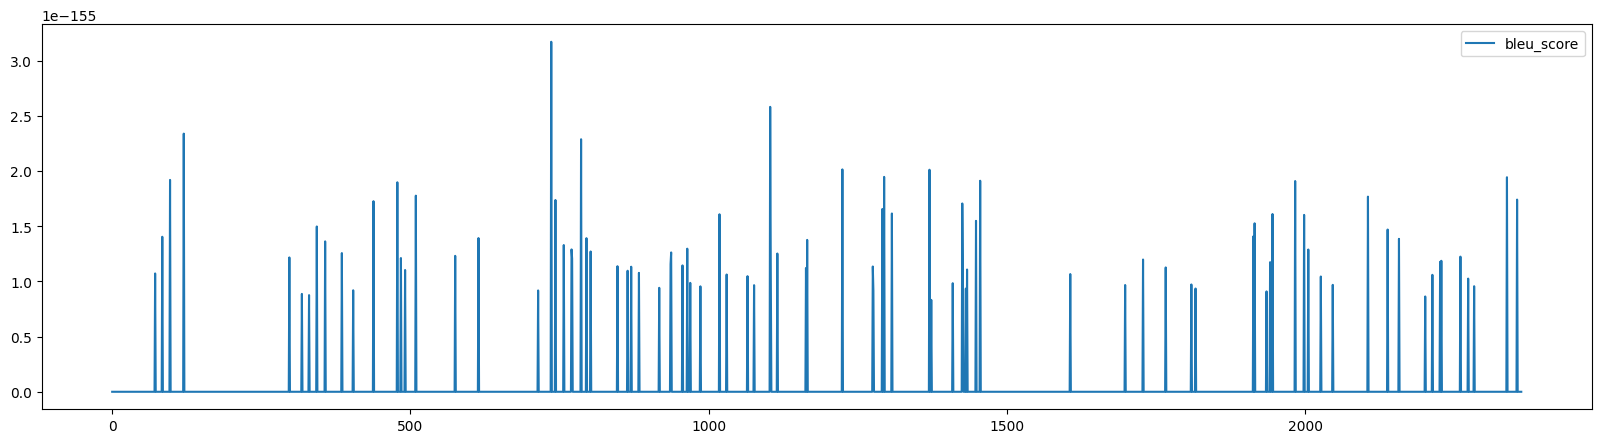

In [44]:
df_aug_2.plot(y='bleu_score', figsize=(20, 5))

In [45]:
filter_df_aug = df_aug_2.loc[(df_aug_2['sent_sim'] >= 0.8) & (df_aug_2['bleu_score'] > 0)]

In [47]:
filter_df_aug.count()

text          1904
label         1904
th_to_en      1904
en_to_th      1904
sent_sim      1904
bleu_score    1904
dtype: int64

In [57]:
new_filter_df_aug = filter_df_aug.drop(columns=['text', 'th_to_en', 'sent_sim', 'bleu_score'])

In [58]:
new_filter_df_aug.reset_index(inplace=True)

In [59]:
new_filter_df_aug.drop(columns='index', inplace=True)

In [60]:
new_filter_df_aug.rename(columns={"en_to_th": 'text'}, inplace=True)

In [61]:
new_filter_df_aug

,label,text
0,0,กระทรวงสาธารณสุขจัดประชุมอย่างเร่งด่วน! ไวรัส ...
1,1,อย่าทิ้ง! เปลือกมะนาวสามารถบรรเทาอาการปวดข้อ |...
2,0,หิมะฝรั่งเศส! เร่งถนนบนภูเขาหลังจากนักท่องเที่...
3,0,ผู้เชี่ยวชาญชี้ให้เห็นว่าผู้คนแห่กันซื้อเนื้อเ...
4,1,พบโครงกระดูกเก่าที่ถ้ำใต้น้ำ เม็กซิโกมีอายุมาก...
...,...,...
1899,0,ต้องเรียนรู้ที่จะกิน! เม็ดมะม่วงหิมพานต์กินกิน...
1900,1,5 ขั้นตอนง่ายๆในการนวดขนาดหน้าอกให้ใหญ่ขึ้นด้ว...
1901,1,การแช่ในผ้าด้วยผงซักฟอกที่เข้มข้นมากที่เราเคยท...
1902,1,การเปิดเผยสูตรฟันขาว 5 สูตรที่จะทำให้ฟันของคุณ...


In [62]:
new_filter_df_aug.to_csv('./train_augment_data.csv')

In [9]:
df3 = pd.read_csv('./train_augment_data.csv')

In [10]:
df3

,label,text
0,0,กระทรวงสาธารณสุขจัดประชุมอย่างเร่งด่วน! ไวรัส ...
1,1,อย่าทิ้ง! เปลือกมะนาวสามารถบรรเทาอาการปวดข้อ |...
2,0,หิมะฝรั่งเศส! เร่งถนนบนภูเขาหลังจากนักท่องเที่...
3,0,ผู้เชี่ยวชาญชี้ให้เห็นว่าผู้คนแห่กันซื้อเนื้อเ...
4,1,พบโครงกระดูกเก่าที่ถ้ำใต้น้ำ เม็กซิโกมีอายุมาก...
...,...,...
1899,0,ต้องเรียนรู้ที่จะกิน! เม็ดมะม่วงหิมพานต์กินกิน...
1900,1,5 ขั้นตอนง่ายๆในการนวดขนาดหน้าอกให้ใหญ่ขึ้นด้ว...
1901,1,การแช่ในผ้าด้วยผงซักฟอกที่เข้มข้นมากที่เราเคยท...
1902,1,การเปิดเผยสูตรฟันขาว 5 สูตรที่จะทำให้ฟันของคุณ...


In [18]:
train_df

,text,label
0,ไก่ลุงเคนกินแล้วมีแต่สารเร่งโต,1
1,เครื่องดื่มต้านCovid-19ค่าพีเอชคือความเป็นด่าง...,1
2,"แค่ฟังชื่อก็ขนลุก!""ต้นป่าช้าเหงา""สมุนไพรชั้นดี...",1
3,พิชัย'แนะ'ประยุทธ์'เพิ่มเซลล์สมองแก้ปัญหาเศรษฐ...,0
4,อุจจาระตกค้างเรื่องใหญ่!แจกสูตรดีท็อกซ์ล้างลำไ...,1
...,...,...
2358,เดี๋ยวนี้มีใบทุเรียนน้ำแกโรคมะเร็งหายขาดจ้า,1
2359,อาหาร8ประเภทที่ไม่ควรนำไปอุ่นซ้ำอีกรอบ|||จะต้อ...,1
2360,เภสัชเผยยากลุ่มNSAIDsห้ามกินร่วมกันเสี่ยงอันตร...,0
2361,สบส.ฟันธง!!วัยทำงานเกือบครึ่งอนาคตเสี่ยงโรคเรื...,0


In [12]:
train_df_with_aug = pd.concat([train_df, df3])

In [20]:
train_df_with_aug.to_csv('./train_data_fake_news_with_aug.csv', index=False)

In [21]:
train_df_with_aug = pd.read_csv('./train_data_fake_news_with_aug.csv')

<AxesSubplot: ylabel='Frequency'>

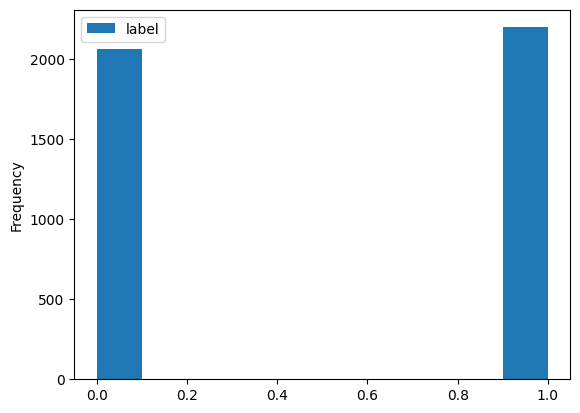

In [24]:
train_df_with_aug.plot.hist()